# 学習型ISTAによるスパース信号再現

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/ISTA.ipynb)

本アルゴリズムは、TISTA (Ito, Takabe, Wadayama, 2019)

https://ieeexplore.ieee.org/document/8695874

をベースとしています(TISTAそのものではありません)。

問題設定は次のとおり：
* 観測過程は $y = x A^T + w$ とする。
* 観測行列$A$は$m \times n$ 実行列
* $A$の各要素はガウス分布（平均0、分散1）に従う。
* $x$は長さnのスパースベクトルであり、ガウス・ベルヌーイ分布に従う。
* 非ゼロ元の生起確率は$p$であり、非ゼロ要素は平均0、分散1のガウス分布に従う。
* $w$は長さmの雑音ベクトルであり、各要素はガウス分布（平均0, 標準偏差sigma）に従う。

## 必要なパッケージのインポート

In [39]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## グローバル定数の設定

In [40]:
m = 150 # 観測ベクトル次元
n = 300 # 元信号ベクトル次元
sigma = 0.05 # 雑音の標準偏差
mbs   = 20 # ミニバッチサイズ
p     = 0.1 # 元信号の非ゼロ元の生起確率
A = torch.normal(torch.zeros(m, n), std = 1.0) # 観測行列
max_itr = 20 # ISTAの反復回数
adam_lr = 0.0001 # Adamの学習率

## ミニバッチ生成関数
* mbs $\times$ n のミニバッチを返す。ひとつの行がスパースベクトルになっている
* 非ゼロ要素は確率$p$で生起する
* 比ゼロ要素の中身は、平均0, 分散1のガウス分布に従う

In [41]:
def gen_minibatch():
    seq = torch.normal(torch.zeros(mbs, n), 1.0) # ガウス乱数ベクトルの生成
    support = torch.bernoulli(p * torch.ones(mbs, n)) # 非ゼロサポートの生成
    return seq * support # 要素ごとの積(アダマール積)になることに注意

## 学習可能なISTA クラス
* アルゴリズムの詳細の説明は5章にて。
* ２種類の学習可能パラメータが導入されている
* 縮小関数として、ソフトしきい値関数を利用

In [42]:
class ISTA(nn.Module):
    def __init__(self, max_itr):
        super(ISTA, self).__init__()
        self.beta = nn.Parameter(0.001*torch.ones(max_itr)) # 学習可能ステップサイズパラメータ
        self.lam  = nn.Parameter(0.1*torch.ones(max_itr)) # 学習可能縮小パラメータ
    def shrinkage(self, x, lam): # 縮小関数 (ソフトしきい値関数)
        return (x-lam)*(x-lam > 0).float() + (x + lam)*(x+lam < 0).float()
    def forward(self, num_itr):
        s = torch.zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            r = s + self.beta[i] * torch.mm(y - torch.mm(s, A.t()), A)  
            s = self.shrinkage(r, self.lam[i]) 
        return s

## 訓練ループ(インクリメンタルトレーニング）

In [43]:
model = ISTA(max_itr)
opt   = optim.Adam(model.parameters(), lr=adam_lr)
loss_func = nn.MSELoss()
for param in model.named_parameters():
    print(param)
for gen in range(max_itr):
    for i in range(50):
        x = gen_minibatch() # 元信号の生成
        w = torch.normal(torch.zeros(mbs, m), sigma)
        y = torch.mm(x, A.t()) + w # 観測信号の生成
        opt.zero_grad()
        x_hat = model(gen + 1)
        loss  = loss_func(x_hat, x) 
        loss.backward()
        opt.step()
    print(gen, loss.item())

('beta', Parameter containing:
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010], requires_grad=True))
('lam', Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000], requires_grad=True))
0 0.056042786687612534
1 0.041032299399375916
2 0.03391558304429054
3 0.02397875301539898
4 0.01930827461183071
5 0.019344337284564972
6 0.013799681328237057
7 0.01244572177529335
8 0.006462314166128635
9 0.006538761779665947
10 0.006115376017987728
11 0.004541406873613596
12 0.005450753960758448
13 0.004436027258634567
14 0.001922374707646668
15 0.004360624123364687
16 0.0030130594968795776
17 0.0013313081581145525
18 0.0018364361021667719
19 0.001941163674928248


## 試験スパース再現

学習の完了したモデルを利用して、スパース信号再現を行い、その結果をプロットする

In [44]:
mbs = 1
x = gen_minibatch()
w = torch.normal(torch.zeros(m), sigma)
y = torch.mm(x, A.t()) + w
s = model(max_itr)

## 元信号の表示

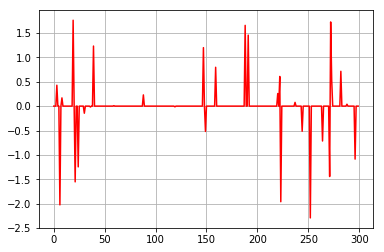

In [45]:
plt.grid()
plt.plot(range(n), x.view(n).cpu().numpy(), color="red")

## 再現信号の表示

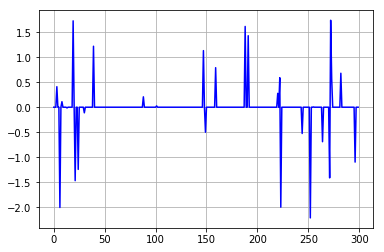

In [46]:
plt.grid()
plt.plot(range(n), s.view(n).detach().numpy(), color="blue")

## 重ねて表示

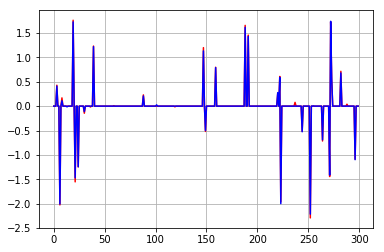

In [47]:
plt.grid()
plt.plot(range(n), x.view(n).detach().numpy(), color="red")
plt.plot(range(n), s.view(n).detach().numpy(), color="blue")

## 学習可能パラメータの表示

In [48]:
print('model.beta = ', model.beta)
print('model.lam = ', model.lam)

model.beta =  Parameter containing:
tensor([ 0.0045,  0.0013,  0.0248,  0.0012,  0.0021,  0.0036,  0.0046,  0.0431,
        -0.0090,  0.0012,  0.0013,  0.0011,  0.0017,  0.0023,  0.0034,  0.0044,
         0.0061,  0.0262, -0.0011,  0.0013], requires_grad=True)
model.lam =  Parameter containing:
tensor([0.1250, 0.1228, 0.1366, 0.1369, 0.1451, 0.1336, 0.1166, 0.0863, 0.0954,
        0.0990, 0.1001, 0.0972, 0.0938, 0.0892, 0.0806, 0.0771, 0.0787, 0.0715,
        0.0800, 0.0881], requires_grad=True)
